`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    #jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines() if "/store/data/Run2017" in s]
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()[::3]] # Every third datafile

In [6]:
#print(jetdatafiles[2]) # Test to see if correct files are collected

In [7]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [8]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        self.prng = RandomState(1234567890)
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["At","at", "0t", "1t", "2t"] #anti-tag+probe, anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 2000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 3)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            'jety':      hist.Hist("Counts", dataset_axis, cats_axis, jety_axis),
            'jetdy':     hist.Hist("Counts", dataset_axis, cats_axis, jetdy_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        # ---- Define Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass']
            )
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size        
        
        # ---- Apply HT Cut ---- #
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        
        # ---- FatJets Info ---- #
        oneFatJet = (FatJets.counts >= 1) # at least one fat jet
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2) # Whats the difference from twoFatJets ?
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        FatJets = FatJets[:,0:2]
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #

        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), self.prng.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for more than one TTbar candidate and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
        
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag_probe,antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        labels_and_categories = dict(zip( self.anacats, cats ))
        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        jety = ttbarcands.p4.rapidity.flatten()
        jetdy = np.abs(ttbarcands.i0.p4.rapidity.flatten() - ttbarcands.i1.p4.rapidity.flatten())
        
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        output['cutflow']['sumw'] += np.sum(weights)
        output['cutflow']['sumw2'] += np.sum(weights**2)
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, p, -9999) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, p, -9999) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"momentum":p}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                file_df = self.lu['at' + str(ilabel[2:])] # get mistag (lookup) filename for 'at'
                bin_widths = file_df['p'].values # collect bins as written in .csv file
                mtr = file_df['M(p)'].values # collect mistag rate as function of p as written in file
                wgts = mtr # Define weights based on mistag rates
                
                BinKey = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                Bins = np.arange(bin_widths.size+1)*100. # Temporary definition of bins as floats
                P = np.where(p>5000., 5000., p) # Avoids momentum larger than the allowed bin size; caps the momentum
                df['BinWidth'] = pd.cut(P, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(P, bins=Bins, labels=BinKey) # new dataframe column
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
            
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = weights*WeightMatching # Include 'wgts' with the previously defined 'weights'
            else:
                Weights = weights # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['jety'].fill(dataset=dataset, anacat=ilabel, 
                                jety=jety[icat],
                                weight=Weights[icat])
            output['jetdy'].fill(dataset=dataset, anacat=ilabel, 
                                jetdy=jetdy[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [9]:
tstart = time.time()

filesets = {
    'QCD':qcdfiles,
    #'TTbar':ttbarfiles,
    #'JetHT':jetdatafiles
}

outputs_unweighted = {}

for name,files in filesets.items(): 

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      chunksize=50000#, maxchunks=4
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    print(elapsed)
    util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output.coffea')

QCD
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f3aca3d0910>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f3aca3d0b90>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f3aca3d0990>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7f3aca3d0d50>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7f3aca3d0810>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7f3aca3d0a10>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7f3aca3d09d0>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7f3aca3d0a50>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7f3aca3d0ad0>, 'subjeteta': <Hist (dataset,ana

In [10]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  177.59858751296997  sec.
Elapsed time =  2.9599764585494994  min.
Elapsed time =  0.04933294097582499  hrs.


In [11]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :     18455107
         one FatJets :       730716
         two FatJets :       708664
              jet id :       708662
             jet kin :       439529
two FatJets and jet kin :       343924
     >= one oneTTbar :       343924
          dPhi > 2.1 :       171516
                sumw :            0
               sumw2 :            0
             At0bcen :          341
             At0bfwd :          307
             At1bcen :           17
             At1bfwd :           15
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         7973
             at0bfwd :         7217
             at1bcen :          277
             at1bfwd :          245
             at2bcen :            3
             at2bfwd :            3
             0t0bcen :        80122
             0t0bfwd :        73500
             0t1bcen :         2049
             0t1bfwd :         1742
             0t2bcen :         

In [12]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [13]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [14]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [15]:
import os

In [16]:
maindirectory = os.getcwd() # change accordingly

/work/TTbarAllHadUproot/MistagPlots/
QCD
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>
<Hist (jetp) instance at 0x7f3ac8d0a410>
<Hist (jetp) instance at 0x7f3ac8d0a790>
mistag_QCD_at0bcen.png saved
QCD
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>
<Hist (jetp) instance at 0x7f3ad05f6890>
<Hist (jetp) instance at 0x7f3ad05f66d0>
mistag_QCD_at0bfwd.png saved
QCD
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>
<Hist (jetp) instance at 0x7f3ad04d7d90>
<Hist (jetp) instance at 0x7f3ad04f41d0>
mistag_QCD_at1bcen.png saved
QCD
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>
<Hist (jetp) instance at 0x7f3ad04e70d0>
<Hist (jetp) instance at 0x7f3ad04e7710>
mistag_QCD_at1bfwd.png saved
QCD
at2bcen
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>
<Hist (jetp) instance at 0x7f3ac8093750>
<Hist (jetp) instance at 0x7f3ac8093b90>
mistag_QCD_at2bcen.png saved
QCD
at2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f3aca494410>


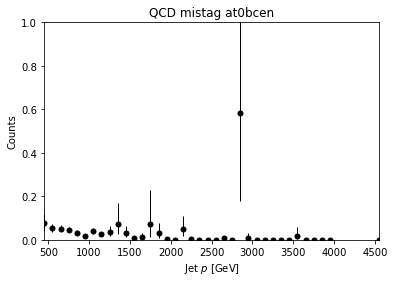

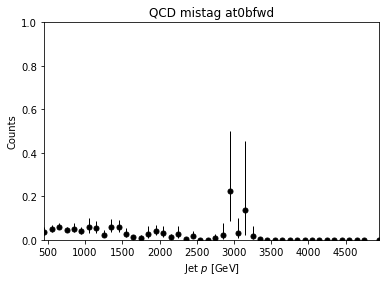

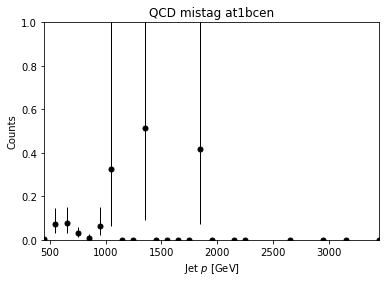

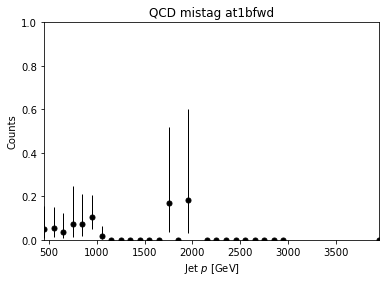

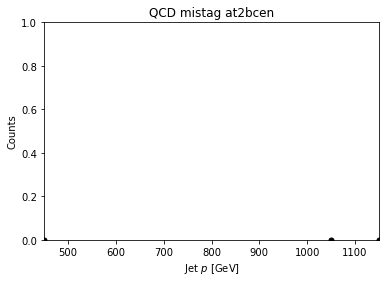

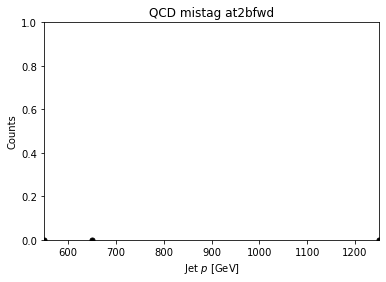

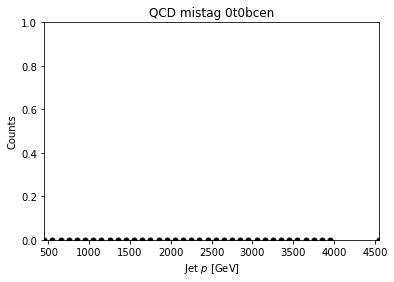

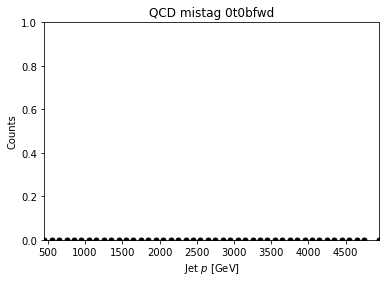

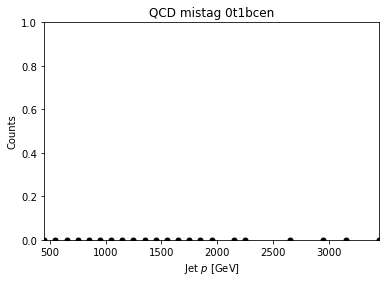

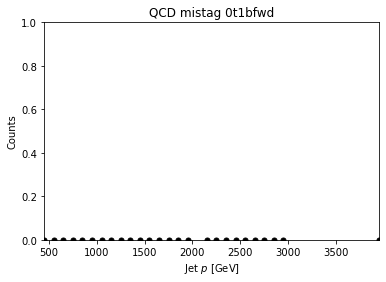

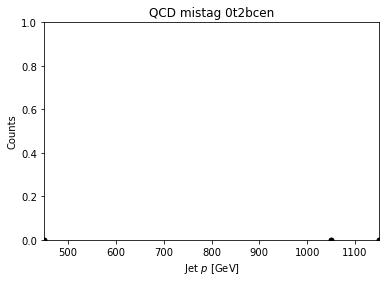

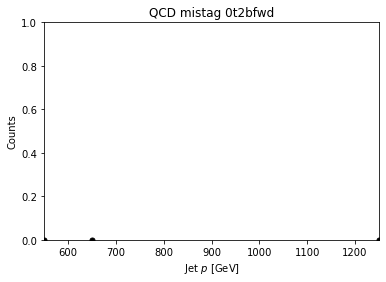

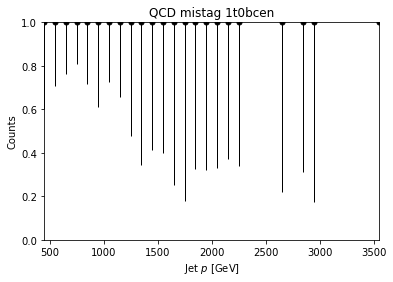

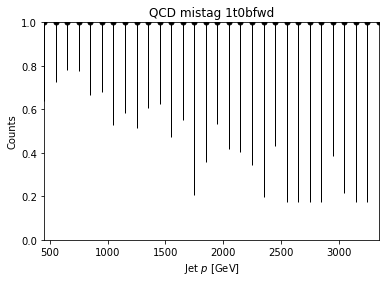

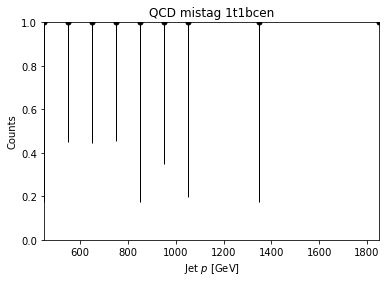

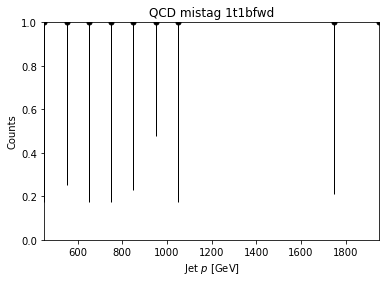

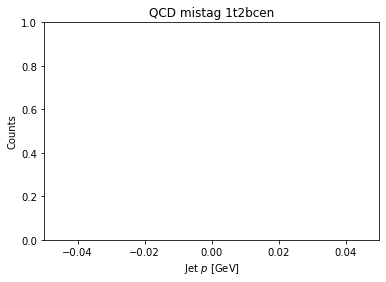

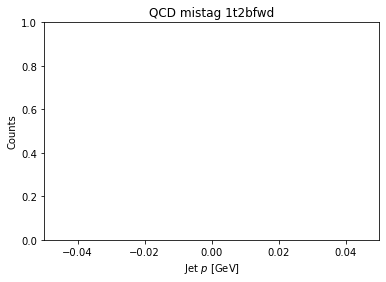

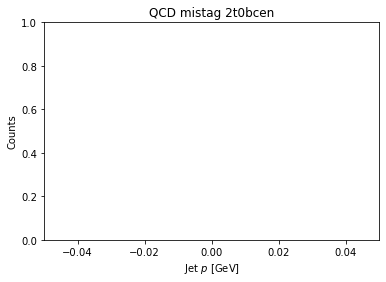

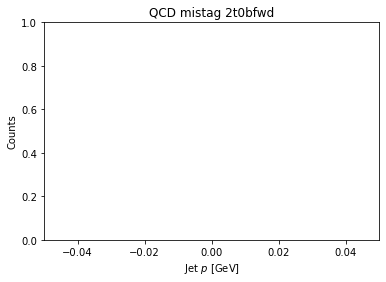

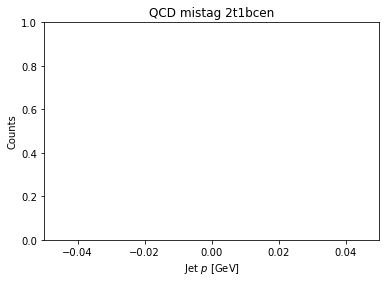

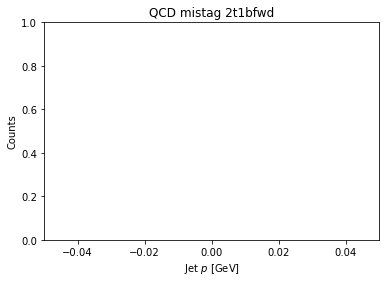

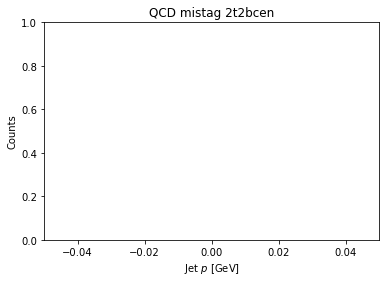

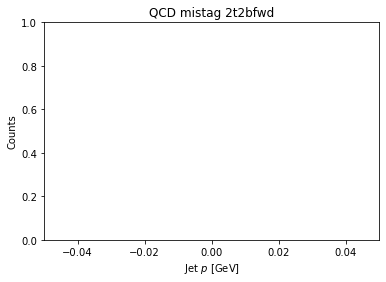

In [17]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(filename + ' saved')


In [18]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #


runLUTS = True 

luts = {}

if runLUTS : 

    SaveDirectory = maindirectory + '/LookupTables/'
    DoesDirectoryExist(SaveDirectory)



    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'

            Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
            Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)

            N_vals = Numerator.values()[()]
            D_vals = Denominator.values()[()]

            mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)

            p_vals = [] # Momentum values
            for iden in Numerator.identifiers('jetp'):
                p_vals.append(iden)

            print('fileset:  ' + iset)
            print('category: ' + icat)
            print('________________________________________________\n')

            d = {'p': p_vals, 'M(p)': mistag_vals}

            df = pd.DataFrame(data=d)
            luts[icat] = df

            #with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            #    print(df)
            #print('\n')

            df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
else : 
    iset = 'QCD'
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
        luts[icat] = pd.read_csv(filename)

		fileset: QCD
*****************************************************

fileset:  QCD
category: at0bcen
________________________________________________

fileset:  QCD
category: at0bfwd
________________________________________________

fileset:  QCD
category: at1bcen
________________________________________________

fileset:  QCD
category: at1bfwd
________________________________________________

fileset:  QCD
category: at2bcen
________________________________________________

fileset:  QCD
category: at2bfwd
________________________________________________

fileset:  QCD
category: 0t0bcen
________________________________________________

fileset:  QCD
category: 0t0bfwd
________________________________________________

fileset:  QCD
category: 0t1bcen
________________________________________________

fileset:  QCD
category: 0t1bfwd
________________________________________________

fileset:  QCD
category: 0t2bcen
________________________________________________

fileset:  QCD
category: 0t2b

In [19]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 103914.71721953999


In [20]:
tstart = time.time()

fileset = {
    'QCD':qcdfiles
}

outputs_weighted = {}

output_weighted = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(UseLookUpTables=True, lu=luts),
                                  executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  #executor=processor.futures_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'skipbadfiles':False,
                                      'workers': 2},
                                  chunksize=50000#, maxchunks=4
                                 )

elapsed = time.time() - tstart
outputs_weighted['QCD'] = output_weighted
print(output_weighted)
print(elapsed)
util.save(output_weighted, 'TTbarResCoffea_full_weighted_QCD_output.coffea')

['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f3ab1c957d0>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f3ab1c95610>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f3ab1c95c10>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7f3ab1c95a90>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7f3ab1c953d0>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7f3ab1c95650>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7f3ab1c95d10>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7f3ab1880b50>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7f3ab1880d50>, 'subjeteta': <Hist (dataset,anacat,

In [21]:
for name,output in outputs_weighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :     18455107
         one FatJets :       730716
         two FatJets :       708664
              jet id :       708662
             jet kin :       439529
two FatJets and jet kin :       343924
     >= one oneTTbar :       343924
          dPhi > 2.1 :       171516
                sumw :            0
               sumw2 :            0
             At0bcen :          341
             At0bfwd :          307
             At1bcen :           17
             At1bfwd :           15
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         7973
             at0bfwd :         7217
             at1bcen :          277
             at1bfwd :          245
             at2bcen :            3
             at2bfwd :            3
             0t0bcen :        80122
             0t0bfwd :        73500
             0t1bcen :         2049
             0t1bfwd :         1742
             0t2bcen :         